# Conformal Regression

Conformal Prediction (CP) は予測区間（prediction intervals）を算出するためのフレームワーク。

予測の残差から予測の幅を算出する。

DMLのcross-fittingのように、train setでは残差の予測モデルをfitせず、分けておいたcalibration setで残差の学習を行う。


## 前提

### 問題設定

$n$個の訓練サンプル$\{(X_i, Y_i)\}_{i=1}^n$があるとし、予測対象のサンプル$(X_{n+1}, Y_{n+1})$もあるとする。
両方のデータ$\{(X_i, Y_i)\}_{i=1}^{n+1}$は **交換可能（exchangeable）** であると仮定する（例えばi.i.d.であるとする）。

$Y_{n+1}$が含まれると思われる marginal distribution-free prediction interval $C(X_{n+1} \subseteq \mathbb{R}$を構築したい。

### exchangeability

サンプル$(X_i, Y_i)$が任意の同時分布$P_{XY}$から得られたものであり、サンプルの順列を変えても変わらないこと。i.i.d.よりは弱い仮定。

例えばサンプルが3つあるとして、$(X_1, Y_1), (X_2, Y_2), (X_3, Y_3)$ と $(X_2, Y_2), (X_1, Y_1), (X_3, Y_3)$ は同じ同時分布を持つということ（[Exchangeable random variables - Wikipedia](https://en.wikipedia.org/wiki/Exchangeable_random_variables)）。

## Conformal Regression

まず、訓練データを2つに分割する

- training set: $\{ (X_i, Y_i): i \in \mathcal{I}_1\}$
- calibration set: $\{ (X_i, Y_i): i \in \mathcal{I}_2\}$

任意の回帰アルゴリズム$\mathcal{A}$を用いて、回帰モデルを訓練する

$$
\hat{\mu}(x) := \mathcal{A}(\{ (X_i, Y_i): i \in \mathcal{I}_1\})
$$

calibration setで残差の絶対値を計算する

$$
R_i=\left|Y_i-\hat{\mu}\left(X_i\right)\right|, \quad i \in \mathcal{I}_2
$$

所与の水準$\alpha$のもとで、絶対残差の経験分布の分位点を計算する

$$
Q_{1-\alpha}\left(R, \mathcal{I}_2\right):=(1-\alpha)\left(1+1 /\left|\mathcal{I}_2\right|\right) \text {-th empirical quantile of }\left\{R_i: i \in \mathcal{I}_2\right\}
$$

新しく与えられた点$X_{n+1}$での予測区間は

$$
C\left(X_{n+1}\right)=\left[\hat{\mu}\left(X_{n+1}\right)-Q_{1-\alpha}\left(R, \mathcal{I}_2\right), \hat{\mu}\left(X_{n+1}\right)+Q_{1-\alpha}\left(R, \mathcal{I}_2\right)\right]
$$


:::{info}
AdaptiveではないConformal Predictionはどのデータ点$X$においても同じQuantile（区間の幅が固定）
:::

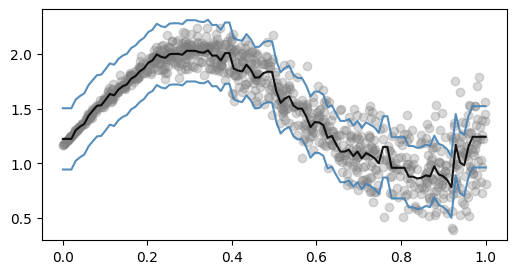

In [64]:
# generate data
import numpy as np
import matplotlib.pyplot as plt
n = 1000
np.random.seed(0)
x = np.random.uniform(low=0, high=1, size=n)
y = x**3 + 2 * np.exp(-6 * (x - 0.3)**2)
y = y + np.random.normal(loc=0, scale=x * 0.3, size=n)

from sklearn.model_selection import train_test_split
X = x.reshape(-1, 1)
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.33, random_state=42)

# calculate residual
from lightgbm import LGBMRegressor
model = LGBMRegressor(verbose=-1)
model.fit(X_train, y_train)
abs_residuals = np.abs(y_cal - model.predict(X_cal))

# aclculate quantile
quantile = np.quantile(abs_residuals, q=0.9)

# plot
x_range = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(x_range.reshape(-1, 1))

fig, ax = plt.subplots(figsize=[6, 3])
ax.scatter(x, y, alpha=0.3, color="gray")
ax.plot(x_range, y_pred, alpha=0.9, color="black")
ax.plot(x_range, y_pred + quantile, alpha=0.9, color="steelblue")
ax.plot(x_range, y_pred - quantile, alpha=0.9, color="steelblue")
fig.show()

## Adaptive Conformal Prediction

区間の幅を可変にしたものの総称？

### Conformalized quantile regression

locally adaptive

[Romano et al. (2019). Conformalized quantile regression.](https://proceedings.neurips.cc/paper/2019/hash/5103c3584b063c431bd1268e9b5e76fb-Abstract.html?ref=https://githubhelp.com)


[Seedat et al. (2023, April). Improving adaptive conformal prediction using self-supervised learning.](https://proceedings.mlr.press/v206/seedat23a/seedat23a.pdf)


## 参考

- [Conformal prediction - Wikipedia](https://en.wikipedia.org/wiki/Conformal_prediction)
- [tidymodels - Conformal inference for regression models](https://www.tidymodels.org/learn/models/conformal-regression/)
- [ryantibs/conformal: Tools for conformal inference in regression](https://github.com/ryantibs/conformal)